In [ ]:
%%HTML
<style>
.rendered_html table{
    width: 80%;
    margin-left:auto; 
    margin-right:auto;
    padding: 20px;
    border: 0px solid black;    
    background-color: #ff;
}
.rendered_html td, .rendered_html th 
{
    vertical-align: top;
    text-align: left;
    font-size: 14px;
    font-face: sans-serif;
}
</style>

<center>
<h1> Analysis and Classification of Periodic Variable Stars</h1>
<h2>Pablo Huijse H. (phuijse at inf dot uach dot cl)</h2>
<h3>Universidad Austral de Chile & Millennium Institute of Astrophysics</h3>
</center>

A tutorial given at the:
- [III LSST-Chile Workshop](https://www.lsst-chile.cl/2017-workshop) @ Santiago, Chile, Dec 13-15
- [School on Systems and Networks (SSN) 2018](http://niclabs.cl/ssn/2018/) @ Valdivia, Chile, Oct 29-31

and running on a jupyterhub at the [NLHPC](http://www.nlhpc.cl/en/) supercomputer *Leftraru*

Thanks to: Juan Carlos Maureira (CMM/UChile) and the organizers

<a href="https://www.space.com/10728-cosmic-visions-paranal-observatory.html">
    <img src="img/intro-paranal.jpg" width="800">
</a>

# Variable stars

- Stars whose brightness change in time
- Different reasons behind this

### Pulsating variables
- Some variable stars pulsate radially
- They expand/heat and contract/cool regularly
- Examples: Cepheid and RR Lyrae

<a href="https://www.youtube.com/watch?v=sXJBrRmHPj8">
    <img src="https://media.giphy.com/media/QP4taxvfVmVEI/giphy.gif" width="300">
</a>

### Eclipsing Binaries

- System of two stars
- The rotational plane is aligned with us
- From our point of view we see brightness decrease with the mutual eclipses

<table>
    <tr><td>
        <a href="http://www.physast.uga.edu/~rls/astro1020/ch16/ovhd.html">
            <img src="img/intro-eb.gif" width="300">
        </a>
    </td>
    <td>
        <a href="https://en.wikipedia.org/wiki/File:Algol_AB_movie_imaged_with_the_CHARA_interferometer_-_labeled.gif">
            <img src="https://media.giphy.com/media/aYb0Ob2GHJ280/giphy.gif" width="300">
        </a>
    </td></tr>
</table>

### Supernovae

- Massive star that runs out of fuel
- Graviational collapse produces massive explosion
- Brightness increases up to 5 billion times our sun

<a href="http://spaceplasma.tumblr.com/post/74724944019/supernova-explosion-artists-impression-one-of">
    <img src="https://media.giphy.com/media/rn79UlSTDfDlS/giphy.gif" width="400">
</a>

# Light curve

- Time series of a star's flux (brightness) on a given passband
- The "apparent" brightness is estimated through **Photometry**
- Variable stars are studied through their light curves

<table><tr><td>
    <img src="img/intro-vista.png" width="250">
</td><td>
    <img src="img/intro-sources.png" width="300">
</td></tr></table>
<img src="img/intro-sources-time.png" width="600">
<img src="img/intro-lc.png" width="400">




# Motivation

- Variable stars as distance tracers: **Cosmology**
<table>
    <tr><td>   
        <img src="img/period-luminosity-relation.gif" width="400">
    </td><td>
        <img src="img/intro-milky-way.jpg" width="400">
    </td></tr><tr><td>
        <a href="http://hyperphysics.phy-astr.gsu.edu/hbase/Astro/dareng.html">
            <img src="img/intro-cosmology.gif" width="400">
        </a>
    </td><td>
        <a href="https://owlcation.com/stem/Einstiens-Cosmolgical-Constant-and-the-Expansion-of-the-Universe">
            <img src="img/intro-darke.jpg" width="400">
        </a>
    </td></tr>
</table>

- Variable star analysis and classification: **Astrophysics**
<a href="http://www.atnf.csiro.au/outreach/education/senior/astrophysics/variable_types.html">
    <img src="img/variable-star-classification.gif" width="400">
</a>

- New methods to analyze astronomical data: **Signal processing** and **Data Science**
    - Room for interdisciplinary research
    - Astroinformatics and Astrostatistics


# Part 1: Finding the period of a variable star

In [1]:
import numpy as np
import P4J
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib import rcParams
rcParams.update({'font.size': 12})
from os import listdir
from os.path import join
import pickle


def fold(mjd, P):
    return np.mod(mjd, P)/P

def plot_folded(ax, phi, mjd, err):
    I = np.argsort(phi)
    ax.errorbar(np.concatenate([phi[I], phi[I]+1.]), 
                np.concatenate([mag[I], mag[I]]),
                np.concatenate([err[I], err[I]]), fmt='.', c='k')
    ax.invert_yaxis(); ax.grid(True)
    

### Light curve data inspection

- Load a light curve from data folder
- Four light curve examples
    1. RR Lyrae (Pulsating variable, short period)
    - Long Period Variable (LPV) 
    - Eclipsing binary
    - Non-periodic light curve
- The columns in the files are the 
    1. **Modified Julian Data (MJD):** Corresponds to time 
    - **Magnitude:** Corresponds to apparent brightness (log scale)
    - **Error:** Photometric error estimation of the magnitude

['lc_lpv.dat', 'lc_eb.dat', 'lc_rrl.dat', 'lc_noisy.dat']


<IPython.core.display.Javascript object>


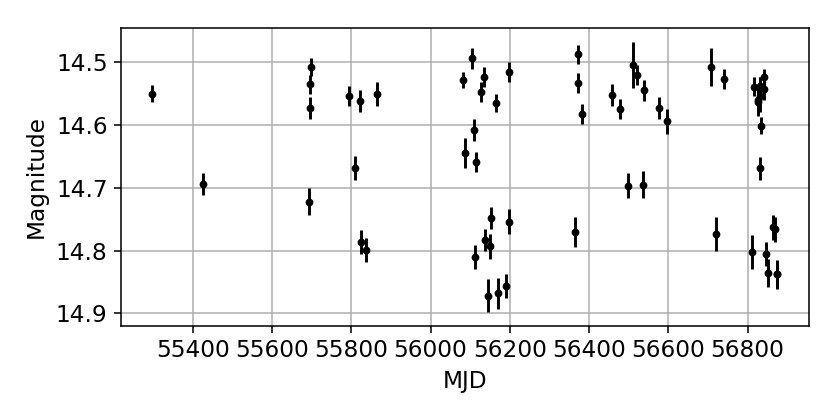

In [45]:
print([each for each in listdir('data') if each.endswith('.dat')])
# Selected one of the light curves
lc_data = np.loadtxt(join('data', 'lc_eb.dat'))
# lc_data = np.loadtxt(join('data', 'lc_rrl.dat'))
mjd, mag, err = lc_data.T
N = len(mjd)

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.errorbar(mjd, mag, err, fmt='.', c='k'); ax.invert_yaxis()
ax.set_xlabel('MJD'); ax.set_ylabel('Magnitude')
ax.grid(True);

### Periodogram

- We want to find the period (fundamental frequency) of the star
- This is generally done using the **Fourier transform** (FT) or correlation
- FT and correlation assumme regular time sampling
- Estimating the period with irregular sampling
    1. Least squares: Lomb-Scargle periodogram
    1. ANOVA periodogram
    1. Conditional Entropy and Mutual Information periodograms
    1. ....

<IPython.core.display.Javascript object>


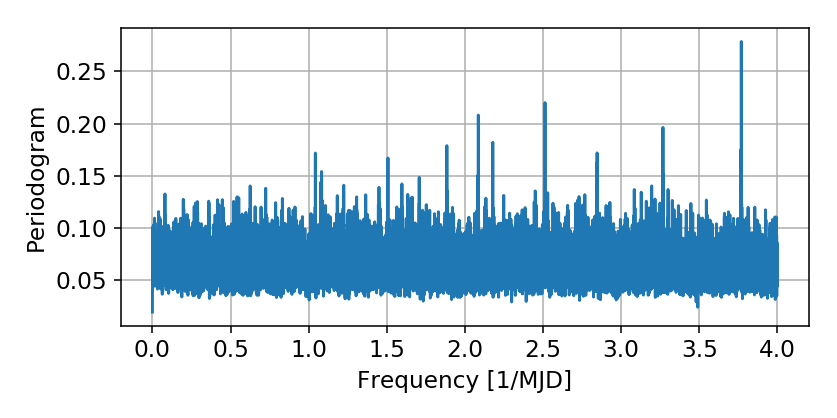

Best period: 0.265308 days


In [3]:
my_per = P4J.periodogram(method='QMIEU') 
my_per.set_data(mjd, mag, err, h_KDE_P=0.25)
my_per.frequency_grid_evaluation(fmin=0.0, fmax=4.0, fresolution=1e-4)
my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=10)
freq, per = my_per.get_periodogram()
fbest, pbest  = my_per.get_best_frequencies()

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.plot(freq, per)
ax.set_xlabel('Frequency [1/MJD]')
ax.set_ylabel('Periodogram')
plt.grid()
print("Best period: %f days" %(1.0/fbest[0]))

### Folding the light curve

- Technique used by astronomers to visually inspect periodic variables
- You need a candidate period $P$ to perform the folding
- The time axis is divided in chucks of size $P$ and plotted on top each other
$$
\phi = \text{modulo}(\text{MJD}, P)/P
$$
- If the $P$ is close to the true period you will see a nice periodic shape
- Otherwise you see a noisy pattern

<IPython.core.display.Javascript object>


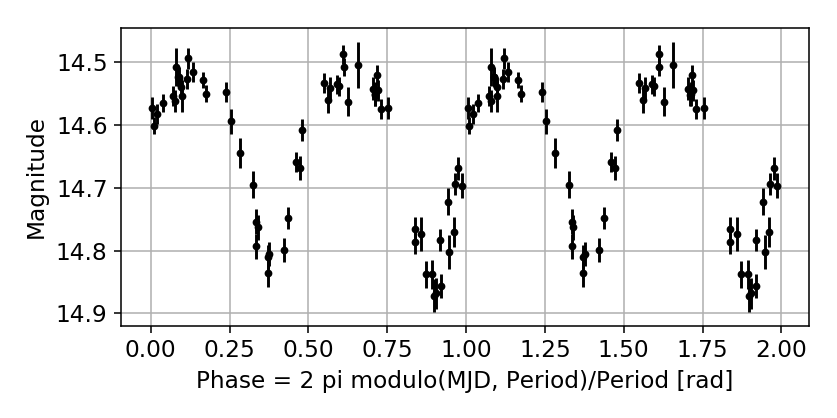

In [5]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
P = 1.0/fbest[0]
plot_folded(ax, np.mod(mjd, P)/P, mag, err)
ax.set_xlabel('Phase = 2 pi modulo(MJD, Period)/Period [rad]')
ax.set_ylabel('Magnitude'); ax.grid(True)

### How significant is this period? 
- The maxima of the periodogram are our test statistic
- Do bootstrap resampling to increase our sample of periodogram maxima"
- Fit a Generalized Extreme Value (GEV) distribution (e.g. Gumbel) to the maxima
- Find $\alpha$ confidence threshold for significance

<IPython.core.display.Javascript object>


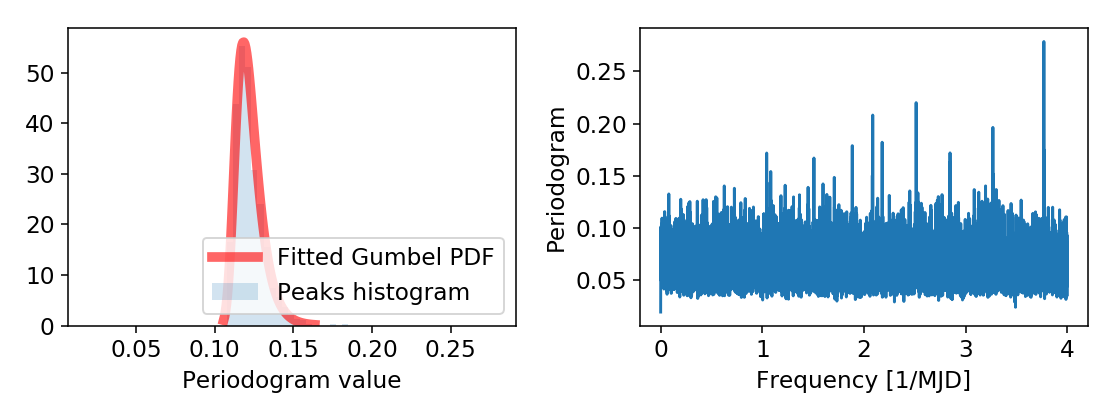

Best period: 0.265308 days


In [42]:
from scipy.stats import gumbel_r

"""
pbest_bootstrap = np.zeros(shape=(10, 100))
for i in range(10):
    P = np.random.permutation(len(mjd))
    my_per.set_data(mjd, mag[P], err[P], h_KDE_P=0.25)
    my_per.frequency_grid_evaluation(fmin=0.0, fmax=4.0, fresolution=1e-4)
    my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=100)
    _, pbest_bootstrap[i, :] = my_per.get_best_frequencies()
"""
fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)
ax[1].plot(freq, per)
ax[1].set_xlabel('Frequency [1/MJD]')
ax[1].set_ylabel('Periodogram')
param = gumbel_r.fit(pbest_bootstrap.ravel())
_ = ax[0].hist(pbest_bootstrap.ravel(), bins=20,
               density=True, alpha=0.2, label='Peaks histogram')
rv = gumbel_r(loc=param[0], scale=param[1])
x = np.linspace(rv.ppf(0.001), rv.ppf(0.999), 100)
ax[0].plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='Fitted Gumbel PDF')
ax[0].set_xlim(ax[1].get_ylim())
ax[0].set_xlabel('Periodogram value'); ax[0].legend(loc=4);
print("Best period: %f days" %(1.0/fbest[0]))

<IPython.core.display.Javascript object>


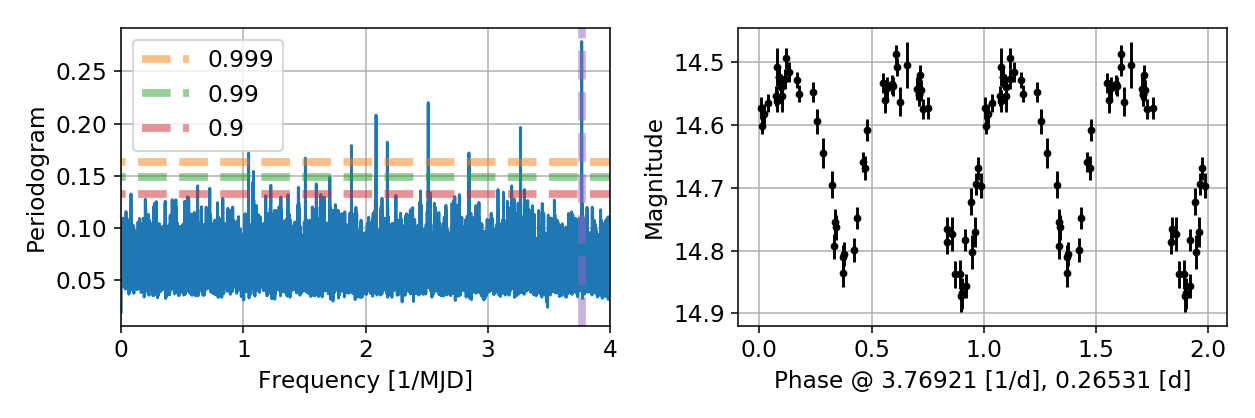

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), tight_layout=True)
ax[0].plot(freq, per)
# Print confidence bars
xmin, xmax = ax[0].get_xlim()
for p_val in [0.999, 0.99, 0.9]:
    ax[0].plot([xmin, xmax], [rv.ppf(p_val), rv.ppf(p_val)], 
               '--', linewidth=4, alpha=0.5, label=str(p_val))
ax[0].legend()
# Print max of periodogram
ymin, ymax = ax[0].get_ylim()
ax[0].set_xlim([0., 4.]); ax[0].set_ylim([ymin, ymax]); ax[0].grid(True)
ax[0].set_xlabel('Frequency [1/MJD]'); ax[0].set_ylabel('Periodogram')
f_fold = fbest[0]; 
ax[0].plot([f_fold, f_fold], [ymin, ymax], '--', linewidth=4, alpha=0.5)
phi = np.mod(mjd, 1.0/f_fold)*f_fold;
plot_folded(ax[1], phi, mag, err)
ax[1].set_xlabel('Phase @ %0.5f [1/d], %0.5f [d]' %(f_fold, 1.0/f_fold))
ax[1].set_ylabel('Magnitude'); 

# Machine Learning

- A paradigm were algorithms **learn** models that map input (data) to a desired response
- Roots in statistics
- Great success in **pattern recognition** problems: Classification, Regression, Prediction
- The user defines the "family" of the model and the **learning rules**
- The user provides **data and targets**
- The user makes sure that the model does not **overfit** the training data
- GOAL: **Generalize** to unseen data

<img src="img/intro-ml.png" width="600">


<a href="https://alykhantejani.github.io/a-brief-introduction-to-gradient-descent/">
    <img src="img/intro-grad.gif" width="600">
</a>

# Neural networks

- Neural networks are parametric models loosely based on our brains
- Interconnected networks of simple units called neurons 
- The parameters of the neuron are learnt through solving an optimization problem
- Many different architectures to solve many different problems

<table><tr><td>
    <img src="img/intro-neuron.png" width="300">
</td><td>
    <img src="img/intro-neuron-model.png" width="300">
</td></tr></table>
<a href="http://www.asimovinstitute.org/neural-network-zoo/">
    <img src="img/intro-nns.png" width="600">
</a>

# Part 2: Getting features from our periodic light curves

- We want to train a neural network to discriminate a particular type of star: **RR Lyrae** 
- Given that we have the period we train on the folded light curve
- To interpolate the folded light curve we use Gaussian processes (GPR) regression

### GPR in a nutshell
1. Define a kernel (covariance matrix). This sets a functional family for our regressor
1. Find the parameters of the kernel by maximum likelihood
1. Use the fitted regressor to predict on new samples (interpolation)
1. We will use the scikit-learn implementation `sklearn.gaussian_process`

<img src="img/intro-GP.png">

In practice:
- **Note 1:** It is recommended to remove outliers before fitting
- **Note 2:** Consider [Heteroscedastic GP regression](http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/heteroscedastic_regression.ipynb) if error bars differ much

ExpSineSquared(length_scale=1.31, periodicity=1) + WhiteKernel(noise_level=0.000273)


<IPython.core.display.Javascript object>


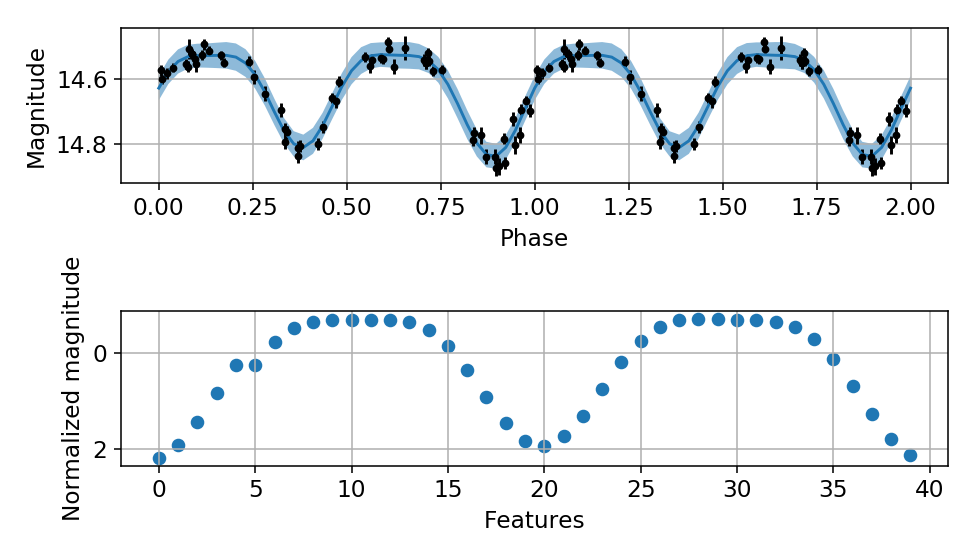

In [50]:
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
gpr = GaussianProcessRegressor(kernel=ExpSineSquared(periodicity=1.0, periodicity_bounds=(0.9999, 1.0001)) \
                               + WhiteKernel(), alpha=err**2, normalize_y=True, n_restarts_optimizer=5)
gpr.fit(X=phi[:, np.newaxis], y=mag[:, np.newaxis])
print(gpr.kernel_)

phi_plot = np.linspace(0.0, 1.0, num=40)[:, np.newaxis]
gp_mu, gp_std = gpr.predict(X=phi_plot, return_std=True)

fig, ax = plt.subplots(2, figsize=(7, 4), tight_layout=True)
ax[0].plot(np.hstack((phi_plot[:, 0], phi_plot[:, 0]+1)), np.hstack((gp_mu[:, 0], gp_mu[:, 0])))

ax[0].fill_between(np.hstack((phi_plot[:, 0], phi_plot[:, 0]+1)), 
                 np.hstack((gp_mu[:, 0], gp_mu[:, 0])) - 2* np.hstack((gp_std, gp_std)), 
                 np.hstack((gp_mu[:, 0], gp_mu[:, 0])) + 2* np.hstack((gp_std, gp_std)), alpha=0.5)
plot_folded(ax[0], phi, mag, err)
ax[0].set_xlabel('Phase'); ax[0].set_ylabel('Magnitude')

idx_max = np.argmax(gp_mu); gp_mu = np.roll(gp_mu, -idx_max)
ax[1].scatter(np.arange(40), (gp_mu - np.median(gp_mu))/np.std(gp_mu))
ax[1].invert_yaxis(); plt.grid()
plt.xlabel('Features'); plt.ylabel('Normalized magnitude');

# Part 3: Trainining a neural network

1. In this part we will train an [autoencoder](https://docs.google.com/presentation/d/1IJ2n8X4w8pvzNLmpJB-ms6-GDHWthfsJTFuyUqHfXg8/edit?usp=sharing) to visualize the feature space 
- We will use [PyTorch](https://pytorch.org/) to create and train the model
- We have light curves labeled as RR Lyrae and light curves with no label
- Can we find unlabeled light curves that belong to the RR Lyrae class?

In [51]:
import torch
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from vae import VAE, live_metric_plotter

# Load GP features computed offline
lc_periods = pickle.load(open("data/lc_periods.pkl", "rb"))
data_P = pickle.load(open("data/features_P.pkl", "rb"))
data_U = pickle.load(open("data/features_U.pkl", "rb"))

# Split data intro train and validation sets
data = np.concatenate((data_P, data_U), axis=0)
labels = np.concatenate((np.ones(shape=(len(data_P), 1)), np.zeros(shape=(len(data_U), 1))))
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
train_idx, valid_idx = next(sss.split(data, labels))
train_dataset = TensorDataset(torch.from_numpy(data[train_idx].astype('float32')))
valid_dataset = TensorDataset(torch.from_numpy(data[valid_idx].astype('float32')))

VAE(
  (enc_hidden): Linear(in_features=47, out_features=16, bias=True)
  (enc_mu): Linear(in_features=16, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=16, out_features=2, bias=True)
  (dec_hidden): Linear(in_features=2, out_features=16, bias=True)
  (dec_mu): Linear(in_features=16, out_features=47, bias=True)
  (dec_logvar): Linear(in_features=16, out_features=1, bias=True)
)
Number of trainable parameters: 1700


<IPython.core.display.Javascript object>


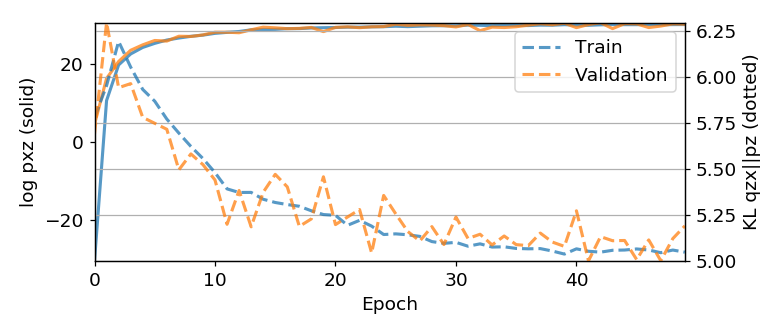

In [52]:
batch_size_, nepochs, mc_samples = 32, 50, 32
torch.manual_seed(0)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size_, shuffle=False)

model = VAE(n_input=47, n_hidden=16, n_latent=2, importance_sampling=True)
print(model)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("Number of trainable parameters: %d" %(sum([np.prod(p.size()) for p in model_parameters])))

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
plotter = live_metric_plotter()
metrics = np.zeros(shape=(nepochs, 2, 2))

for epoch in range(nepochs):
    # Train 
    for x_batch, in train_loader:
        optimizer.zero_grad()        
        dec_mu, dec_logvar, enc_mu, enc_logvar, z = model.forward(x_batch, mc_samples)
        loss, rec_loss, reg_loss = model.ELBO(x_batch.unsqueeze(1), dec_mu, dec_logvar, enc_mu, enc_logvar, z)        
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)        
        optimizer.step()
        metrics[epoch, 0, 0] += rec_loss.detach().numpy()/len(train_dataset)
        metrics[epoch, 0, 1] += reg_loss.detach().numpy()/len(train_dataset)
    # Test
    for x_batch, in valid_loader:
        dec_mu, dec_logvar, enc_mu, enc_logvar, z = model.forward(x_batch, mc_samples)
        loss, rec_loss, reg_loss = model.ELBO(x_batch.unsqueeze(1), dec_mu, dec_logvar, enc_mu, enc_logvar, z)
        metrics[epoch, 1, 0] += rec_loss.detach().numpy()/len(valid_dataset)
        metrics[epoch, 1, 1] += reg_loss.detach().numpy()/len(valid_dataset)
    
    if epoch > 0:
        plotter.update(epoch, metrics)

<IPython.core.display.Javascript object>


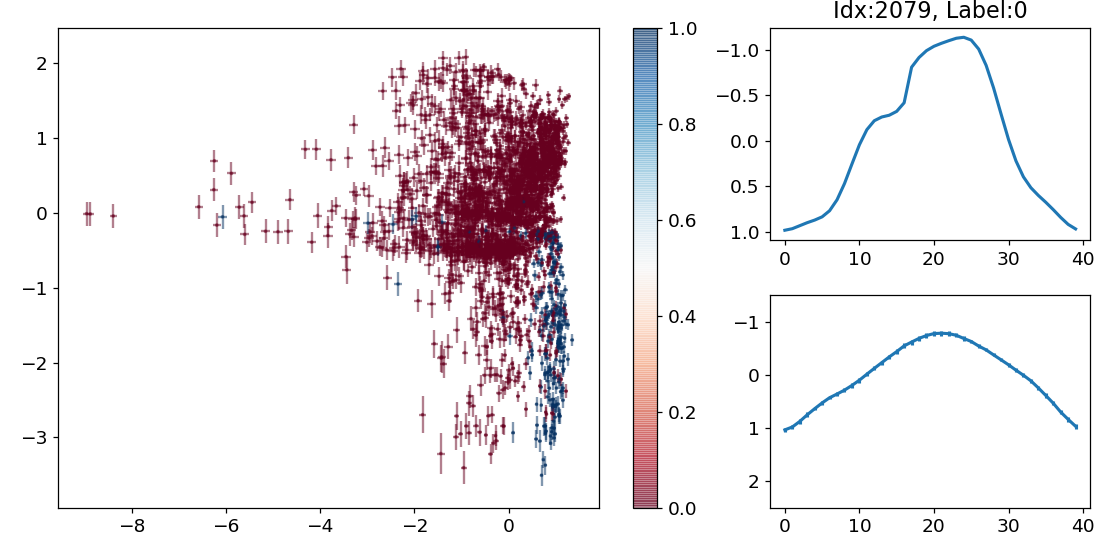

In [63]:
test_dec_mu, test_dec_logvar, test_enc_mu, test_enc_logvar, test_z = model.forward(valid_dataset.tensors[0], k=10)
test_enc_mu, test_enc_sigma = test_enc_mu.detach().numpy(), (test_enc_logvar.detach()*0.5).exp().numpy()
test_dec_mu = test_dec_mu.detach().numpy()

"""
The figure shows the digits in latent space as a dot (mean of the variational posterior) with 
errorbars (standard deviation of the variational posterior). Each point is a distribution!
"""
fig = plt.figure(figsize=(10, 5), dpi=80)
ax_main = plt.subplot2grid((2, 3), (0, 0), colspan=2, rowspan=2)
ax_ori = plt.subplot2grid((2, 3), (0, 2))
ax_rec = plt.subplot2grid((2, 3), (1, 2))
a, b, c = ax_main.errorbar(x=test_enc_mu[:, 0], y=test_enc_mu[:, 1], 
                           xerr=test_enc_sigma[:, 0], yerr=test_enc_sigma[:, 1], 
                           fmt='none', alpha=0.5, zorder=-1)
sc = ax_main.scatter(test_enc_mu[:, 0], test_enc_mu[:, 1], s=2, alpha=0.5, 
                     c=labels[valid_idx, 0], cmap=plt.cm.RdBu)
clb = plt.colorbar(sc, ax=ax_main)
for i in range(2):
    c[i].set_color(clb.to_rgba(labels[valid_idx, 0]))
    
ax_ori.plot(np.arange(40), data[valid_idx][0][:40], linewidth=2); 
ax_rec.errorbar(np.arange(40), np.mean(test_dec_mu[0], axis=0)[:40], 
                2*np.std(test_dec_mu[0], axis=0)[:40], linewidth=2); 
for ax in [ax_rec, ax_ori]:
    ax.invert_yaxis();
    ax.set_ylim([2.5, -1.5]); 
    
c_lim, r_lim = ax_main.get_xlim(), ax_main.get_ylim()
plt.tight_layout()

def onclick(event):
    z_closest = [event.xdata, event.ydata]
    print(z_closest)
    idx = np.argmin(np.sum((test_enc_mu - z_closest)**2, axis=1))
    ax_ori.cla(); ax_ori.set_title("Idx:%d, Label:%d" %(idx, labels[valid_idx][idx, 0]))
    ax_ori.plot(np.arange(40), data[valid_idx][idx][:40], linewidth=2); 
    ax_ori.invert_yaxis(); 
    # lc_single = lc_raw[valid_idx[idx]]; period_single = lc_period_raw[valid_idx[idx]]
    # mean =  np.median(lc_single[:,1]); std = np.std(lc_single[:,1])
    #ax_ori.errorbar(40*np.mod(lc_single[:,0], period_single)/period_single, 
    #                (lc_single[:,1] - mean)/std, lc_single[:,2]/std,fmt='.', c='k')
    ax_rec.cla(); ax_rec.invert_yaxis(); ax_rec.set_ylim([2.5, -1.5]); 
    ax_rec.errorbar(np.arange(40), np.mean(test_dec_mu[idx], axis=0)[:40], 
                    2*np.std(test_dec_mu[idx], axis=0)[:40], linewidth=2); 
    
cid = fig.canvas.mpl_connect('button_press_event', onclick);